# Hello there!

The following code was developed for **predicting the presence or absence of cardiovascular disease** based on a dataset containing information of over 70,000 patients.
If you which to see more about the project, please go to de [README](https://github.com/diandramelo/Cardio_Catch_Diseases/blob/main/README.md) file and/or the [Storytelling](https://github.com/diandramelo/Cardio_Catch_Diseases/blob/main/Project_Storytelling.pdf) slides presentation. 

# 0. IMPORTS

## 0.1. Load Libraries

In [94]:
# data analysis / cleaning / visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# feature selection
from boruta                  import BorutaPy

# feature engineering
from sklearn                 import preprocessing, metrics
from scipy.stats             import chi2_contingency
from sklearn.preprocessing   import MinMaxScaler, RobustScaler

# pre-modelling
from sklearn.model_selection import train_test_split, GridSearchCV

# machine learning models
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC

# metrics
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics         import confusion_matrix

# cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score

# visualization tools
from IPython.display         import Image
from tabulate                import tabulate

## 0.2. Data Import

In [2]:
df_train = pd.read_csv('data/cardio_train.csv', delimiter = ';')

## 0.3. Helper Functions

In [97]:
def cramer_v(var1,var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Crosstab building
    chi2 = chi2_contingency(crosstab)[0]
    n = np.sum(crosstab)
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1) 
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def ml_performance(model_name, y, yhat):
    accuracy = accuracy_score(y, yhat)
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    roc_auc = roc_auc_score(y, yhat)
    
    return pd.DataFrame({'Model Name': model_name, 
                         'Accuracy': accuracy, 
                         'Precision': precision,
                         'Recall': recall,
                         'F1 Score': f1,
                         'AUC ROC': roc_auc}, index = [0])

def cross_validation(model_name, model, x, y, cv):
    cv_accuracy = cross_val_score(model, x, y, cv = cv, scoring = 'accuracy', n_jobs = -1).mean()
    cv_precision = cross_val_score(model, x, y, cv = cv, scoring = 'precision', n_jobs = -1).mean()
    cv_recall = cross_val_score(model, x, y, cv = cv, scoring = 'recall', n_jobs = -1).mean()
    cv_f1 = cross_val_score(model, x, y, cv = cv, scoring = 'f1', n_jobs = -1).mean()
    cv_roc_auc = cross_val_score(model, x, y, cv = cv, scoring = 'roc_auc', n_jobs = -1).mean()
    
    # for future addition of std:
    # accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
    # accuracy = "{:.4f} +/- %{:.4f}".format(accuracy_cv.mean(), accuracy_cv.std())
    
    return pd.DataFrame({'Model Name': model_name, 
                         'Accuracy': cv_accuracy, 
                         'Precision': cv_precision,
                         'Recall': cv_recall,
                         'F1 Score': cv_f1,
                         'AUC ROC': cv_roc_auc}, index = [0])

## 0.4. Graph visualization

In [4]:
from IPython.core.display import HTML

def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [18, 8]
   plt.rcParams['font.size'] = 20
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )
   sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. DESCRIBE DATA 

In [5]:
df1 = df_train.copy()

In [6]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.1. Rename Columns

In [7]:
cols_old = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 
            'alco', 'active', 'cardio']

df1 = df1.rename(columns = {'ap_hi': 'systolic_bp', 'ap_lo': 'diastolic_bp', 'gluc': 'glucose', 
                     'smoke': 'smoking', 'alco': 'alcohol_intake','active': 'physical_activity', 
                     'cardio': 'cardio_disease'})

In [8]:
df1.head()

,id,age,gender,height,weight,systolic_bp,diastolic_bp,cholesterol,glucose,smoking,alcohol_intake,physical_activity,cardio_disease
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.2. Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 70000
Number of columns: 13


## 1.3. Data Types

In [10]:
df1.dtypes

id                     int64
age                    int64
gender                 int64
height                 int64
weight               float64
systolic_bp            int64
diastolic_bp           int64
cholesterol            int64
glucose                int64
smoking                int64
alcohol_intake         int64
physical_activity      int64
cardio_disease         int64
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

id                   0
age                  0
gender               0
height               0
weight               0
systolic_bp          0
diastolic_bp         0
cholesterol          0
glucose              0
smoking              0
alcohol_intake       0
physical_activity    0
cardio_disease       0
dtype: int64

## 1.5. Fillout NA
(Not necessary)

## 1.6. Change Data Type

In [12]:
df1[['gender', 'cholesterol', 'glucose', 'smoking', 'alcohol_intake', 'physical_activity', 
          'cardio_disease']] = df1[['gender', 'cholesterol', 'glucose', 'smoking', 'alcohol_intake', 
          'physical_activity', 'cardio_disease']].astype('object')

In [13]:
df1.dtypes

id                     int64
age                    int64
gender                object
height                 int64
weight               float64
systolic_bp            int64
diastolic_bp           int64
cholesterol           object
glucose               object
smoking               object
alcohol_intake        object
physical_activity     object
cardio_disease        object
dtype: object

## 1.7. Descriptive Statistics


In [14]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1. Numerical Variables

In [15]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.mean())
ct2 = pd.DataFrame(num_attributes.median())

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.std())
d2 = pd.DataFrame(num_attributes.min())
d3 = pd.DataFrame(num_attributes.max())
d4 = pd.DataFrame(num_attributes.max() - num_attributes.min())
d5 = pd.DataFrame(num_attributes.skew())
d6 = pd.DataFrame(num_attributes.kurtosis())

# concat
df_num = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6], axis = 1)
df_num.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_num

,mean,median,std,min,max,range,skew,kurtosis
id,49972.419900,50001.5,28851.302323,0.0,99999.0,99999.0,-0.001278,-1.198374
age,19468.865814,19703.0,2467.251667,10798.0,23713.0,12915.0,-0.307055,-0.823447
height,164.359229,165.0,8.210126,55.0,250.0,195.0,-0.642187,7.943653
weight,74.205690,72.0,14.395757,10.0,200.0,190.0,1.012070,2.586825
systolic_bp,128.817286,120.0,154.011419,-150.0,16020.0,16170.0,85.296214,7580.074738
diastolic_bp,96.630414,80.0,188.472530,-70.0,11000.0,11070.0,32.114083,1425.914585


### 1.7.2. Categorical Variables

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender               2
cholesterol          3
glucose              3
smoking              2
alcohol_intake       2
physical_activity    2
cardio_disease       2
dtype: int64

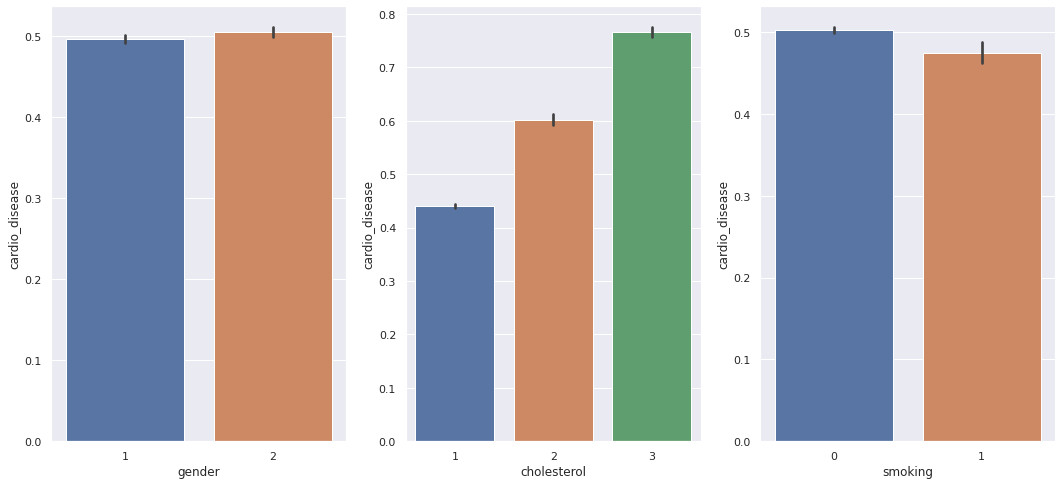

In [17]:
plt.subplot(1,3,1)
sns.barplot(x = "gender", y = "cardio_disease", data = df1);

plt.subplot(1,3,2)
sns.barplot(x = "cholesterol", y = "cardio_disease", data = df1);

plt.subplot(1,3,3)
sns.barplot(x = "smoking", y = "cardio_disease", data = df1);

# 2. FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

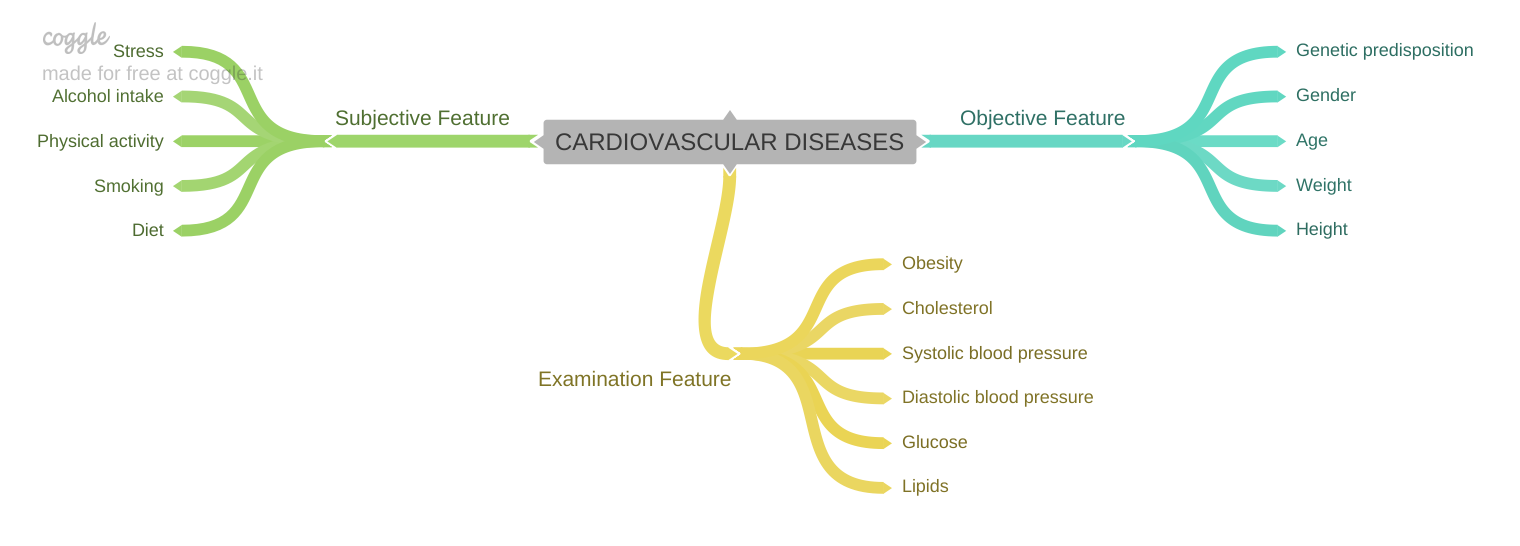

In [17]:
Image(filename='img/CARDIOVASCULAR_DISEASES.png')

## 2.2. Hypothesis Development

### 2.2.1. Objective Features

**1.** People with **some genetic predisposition** are **most likely to present** cardiovascular diseases.

**2.** **Men** are most likely to **present** cardiovascular diseases.

**3.** People with **overweight** are **most likely to present** cardiovascular diseases.

**4.** **Older** people are **most likely to present** cardiovascular diseases.

### 2.2.2. Subjective Features

**1.** People dealing with more daily **stress** are **most likely to present** cardiovascular diseases.

**2.** People who **drink alcohol** are **most likely to present** cardiovascular diseases.

**3.** People who practice regular **physical activities** are **less likely to present** cardiovascular diseases.

**4.** People who **smoke** are **most likely to present** cardiovascular diseases.

**5.** People with a **regular and healthy diet** are **less likely to present** cardiovascular diseases.

### 2.2.3. Examination Features

**1.** People with **obesity** are **most likely to present** cardiovascular diseases.

**2.** People who present **high cholesterol levels** are **most likely to present** cardiovascular diseases.

**3.** **High glucose levels** people are **most likely to present** cardiovascular diseases.

**4.** People with **hypertension** are **most likely to present** cardiovascular diseases.

## 2.3. Feature Engineering

### 2.3.1. Modified Columns

In [19]:
df2['age'] = (df2['age']/365).astype('int64')

df2['gender'] = df2['gender'].apply(lambda x: 'feminine' if x == 1 else 'masculine')

df2['height'] = df2['height']/100

df2['cholesterol'] = df2['cholesterol'].apply(lambda x: 'normal' if x == 1 else 'above_normal' if x == 2 else 'well_above_normal')

df2['glucose'] = df2['glucose'].apply(lambda x: 'normal' if x == 1 else 'above_normal' if x == 2 else 'well_above_normal')

### 2.3.2. Created Columns

In [20]:
df2['bp_level'] = df2['systolic_bp'].apply(lambda x: 'normal' if x < 130 else 'pre_hypertension' if 130 <= x < 140 
                                           else 'hypertension')

df2['BMI'] = (df2['weight'] / np.square(df2['height'])).round(1)

# 3. VARIABLE FILTERING

In [21]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [22]:
df3 = df3[(df3['systolic_bp'] >= 80) & (df3['systolic_bp'] <= 240) 
          & (df3['diastolic_bp'] >= 50) & (df3['diastolic_bp'] <= 140)]

df3 = df3[(df3['height'] > 1.20) & (df3['height'] <= 2.10) 
          & (df3['weight'] >= 40) & (df3['BMI'] <= 60)]

## 3.2. Columns Selection

In [23]:
df3 = df3.drop('id', axis = 1)

# 4. EXPLORATORY DATA ANALYSIS

In [24]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

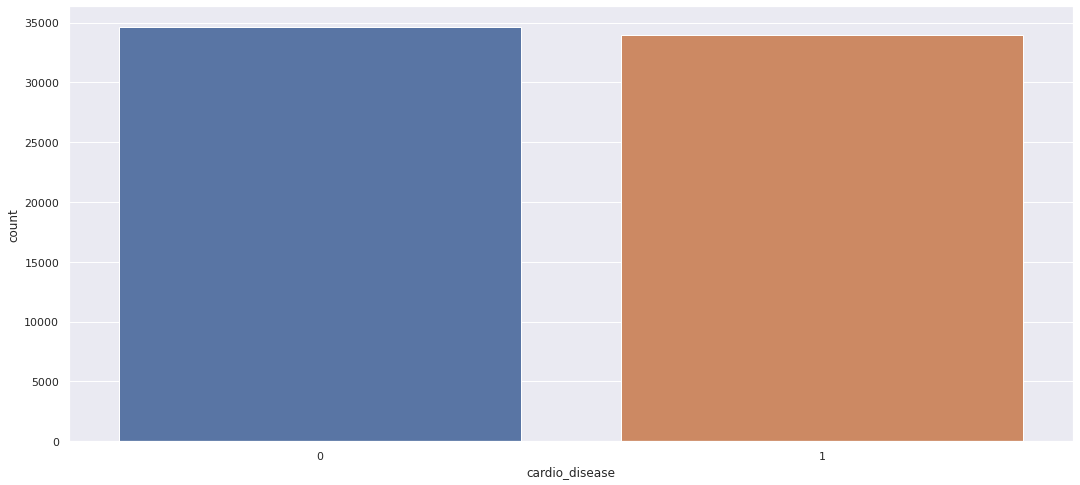

In [17]:
sns.countplot(x = df4['cardio_disease']);

### 4.1.2. Numerical Variables

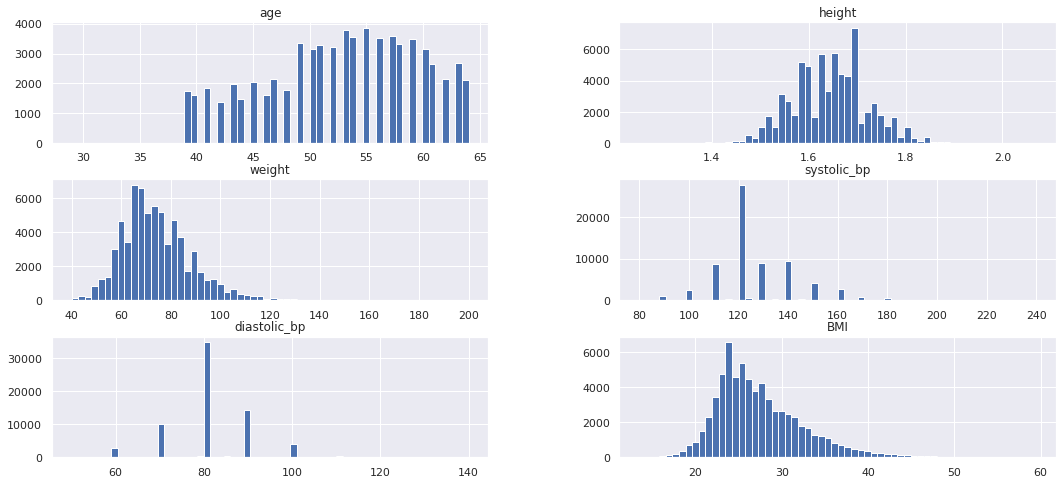

In [60]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])

num_attributes.hist(bins = 60);

### 4.1.3. Categorical Variables

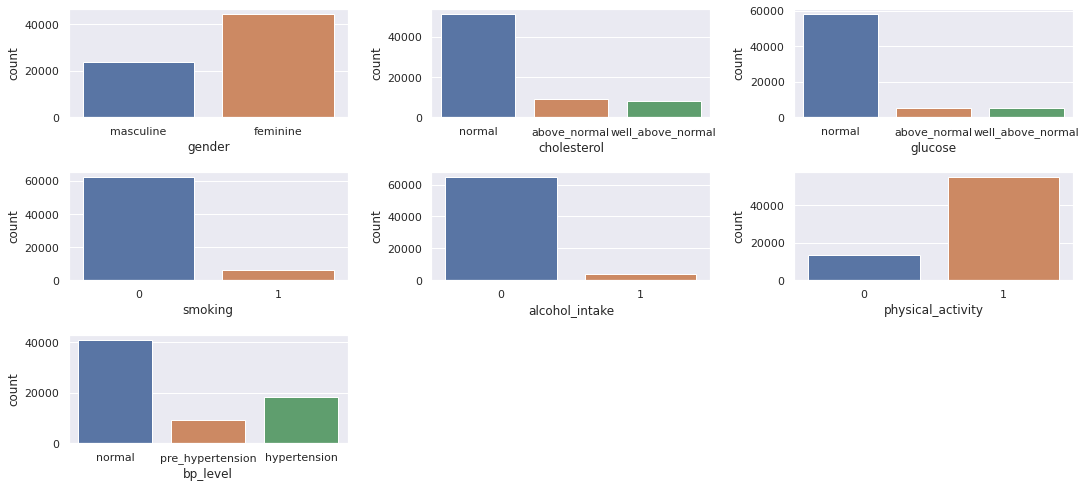

In [22]:
cat_attributes = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

# gender`, `cholesterol`, `glucose`, `smoking`, `alcohol_intake` and `physical_activity`, bp_level

plt.subplot(3, 3, 1)
sns.countplot(x = df4['gender']);

plt.subplot(3, 3, 2)
sns.countplot(x = df4['cholesterol'], order = ('normal', 'above_normal', 'well_above_normal'));

plt.subplot(3, 3, 3)
sns.countplot(x = df4['glucose'], order = ('normal', 'above_normal', 'well_above_normal'));

plt.subplot(3, 3, 4)
sns.countplot(x = df4['smoking']);

plt.subplot(3, 3, 5)
sns.countplot(x = df4['alcohol_intake']);

plt.subplot(3, 3, 6)
sns.countplot(x = df4['physical_activity']);

plt.subplot(3, 3, 7)
sns.countplot(x = df4['bp_level'], order = ('normal', 'pre_hypertension', 'hypertension'));

plt.subplots_adjust(wspace = 0.3, hspace = 0.5);

## 4.2. Bivariate Analysis

### 4.2.1. Individual Analysis of the Hypothesis

**H1.** **Men** are most likely to **present** cardiovascular diseases.

**TRUE**, although difference in percentage is not expressive.

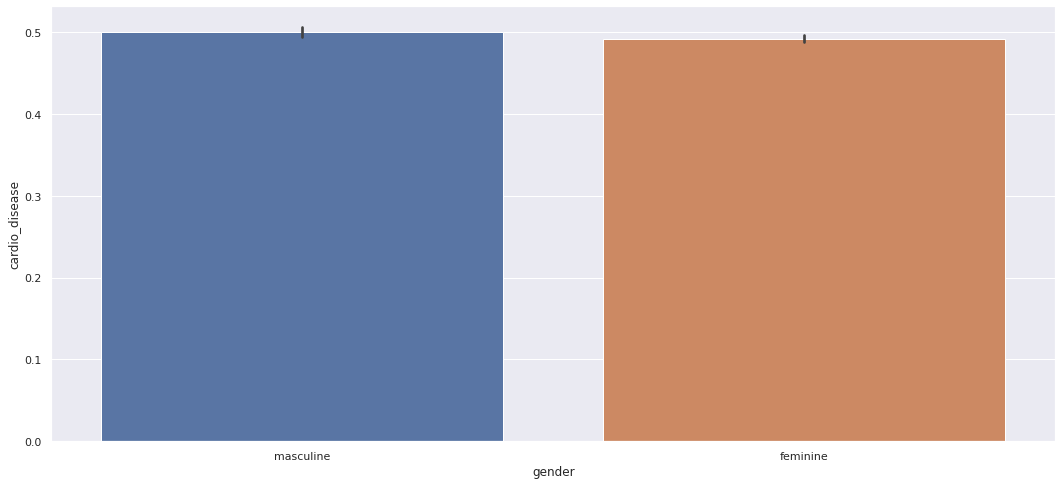

In [103]:
sns.barplot(x = "gender", y = "cardio_disease", data = df4);

**H2.** People with **obesity** are **most likely to present** cardiovascular diseases.

**TRUE**, as well as people with underweight tend to have less cadiac diseases.

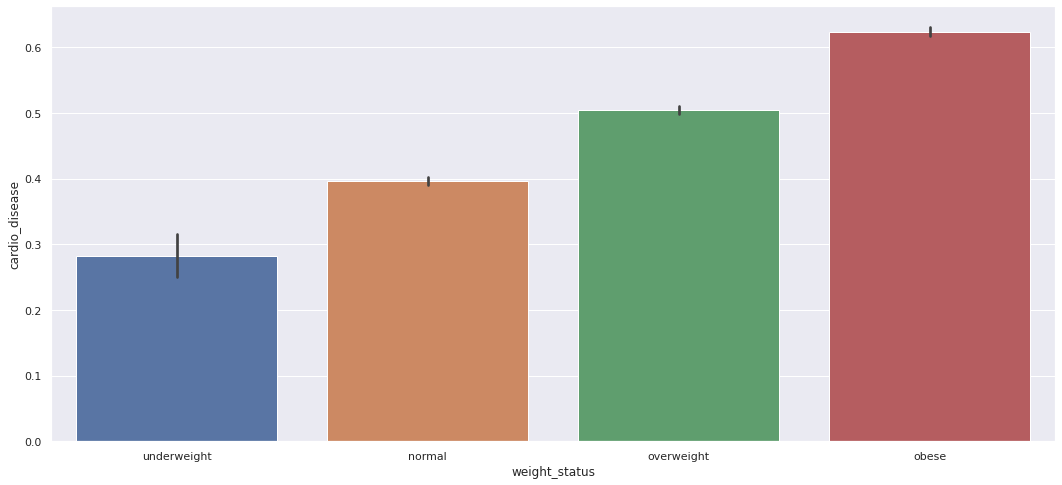

In [333]:
sns.barplot(x = 'weight_status', y = 'cardio_disease', data = df4, order = ('underweight', 'normal', 'overweight', 'obese'));

**H3.** **Older** people are **most likely to present** cardiovascular diseases.

**TRUE**

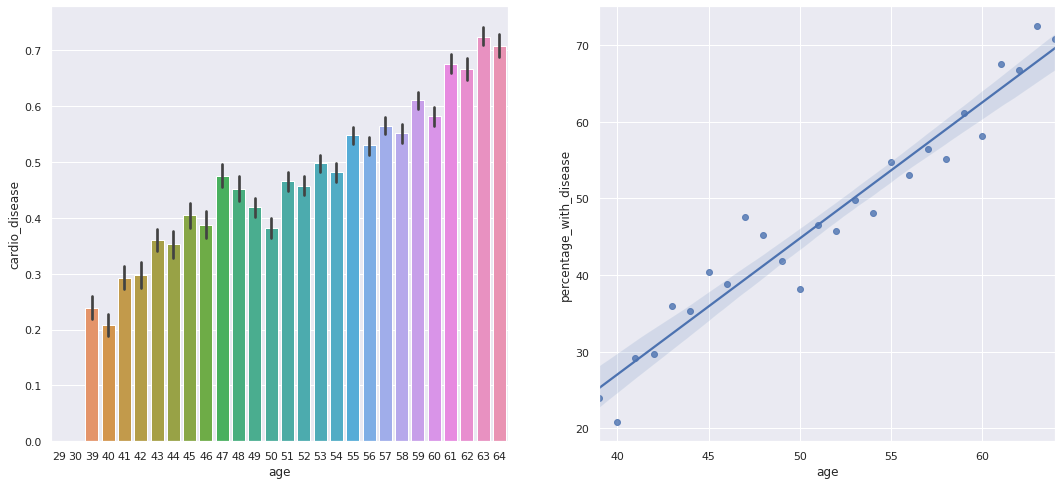

In [306]:
aux = df4.groupby(['age', 'cardio_disease']).agg({'cardio_disease': 'count'})

aux1 = aux.groupby(level = 0).apply(lambda x: (100 * x / float(x.sum())).round(2)).reset_index(0)
aux1 = aux1[aux1.index == 1].rename(columns = {'cardio_disease': 'percentage_with_disease'})

plt.subplot(1, 2, 1)
sns.barplot(x = 'age', y = 'cardio_disease', data = df4);

plt.subplot(1, 2, 2)
sns.regplot(x = 'age', y = 'percentage_with_disease', data = aux1);

**H4.** People who **drink alcohol** are **most likely to present** cardiovascular diseases.

**FALSE**, although difference in percentage is not very expressive.

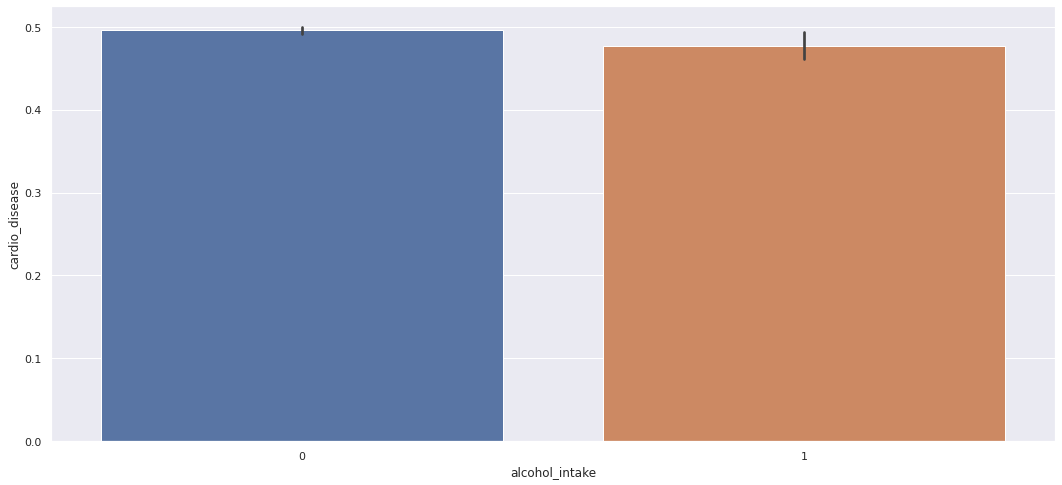

In [313]:
sns.barplot(x = 'alcohol_intake', y = 'cardio_disease', data = df4);

**H5.** People who practice regular **physical activities** are **less likely to present** cardiovascular diseases.

**TRUE**

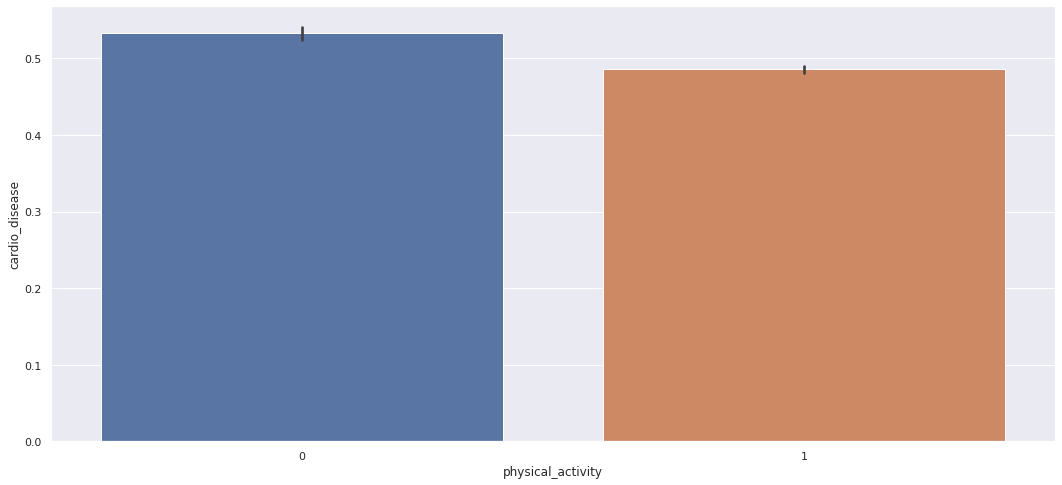

In [314]:
sns.barplot(x = 'physical_activity', y = 'cardio_disease', data = df4);

**H6.** People who **smoke** are **most likely to present** cardiovascular diseases.

**FALSE**, although difference in percentage is not very expressive.

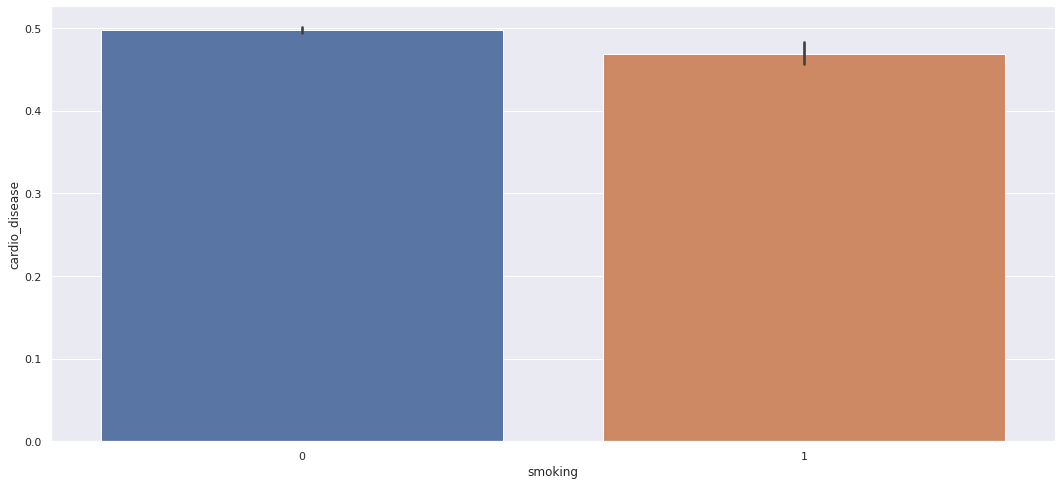

In [315]:
sns.barplot(x = 'smoking', y = 'cardio_disease', data = df4);

**H7.** People who present **high cholesterol levels** are **most likely to present** cardiovascular diseases.

**TRUE**, and those variables seems to have a strong correlation

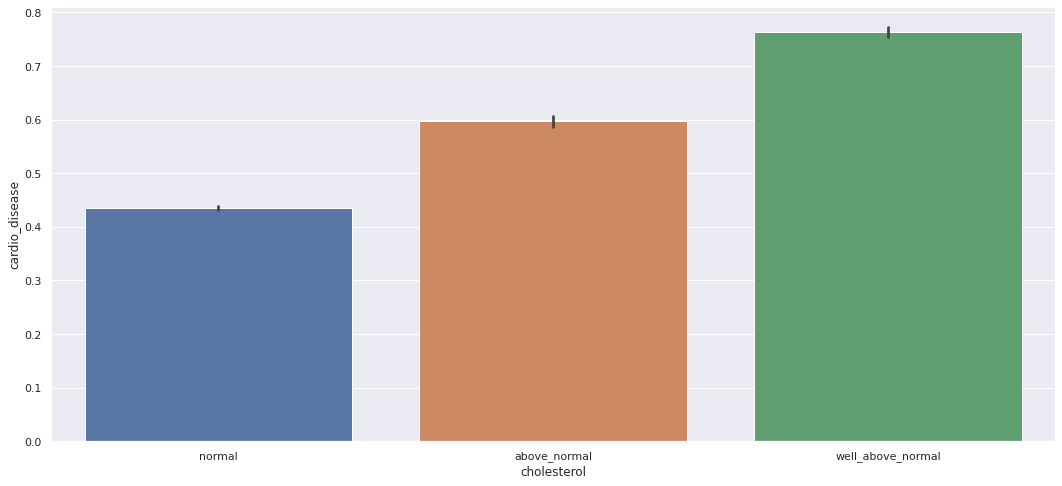

In [317]:
sns.barplot(x = 'cholesterol', y = 'cardio_disease', data = df4, order = ('normal', 'above_normal', 'well_above_normal'));

**H8.** **High glucose levels** people are **most likely to present** cardiovascular diseases.

**TRUE**

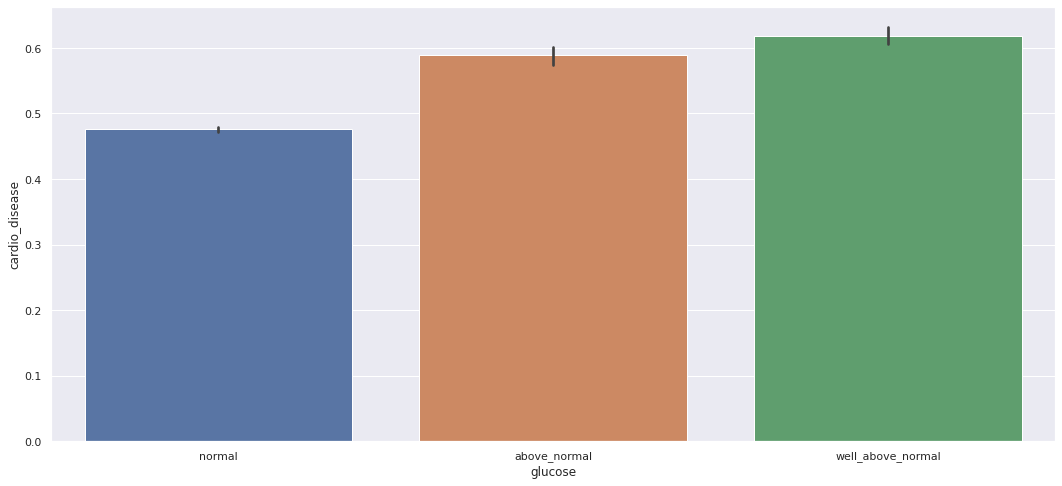

In [318]:
sns.barplot(x = 'glucose', y = 'cardio_disease', data = df4);

**H9.** People with **hypertension** are **most likely to present** cardiovascular diseases.

**TRUE**, and those variables seems to have a strong correlation

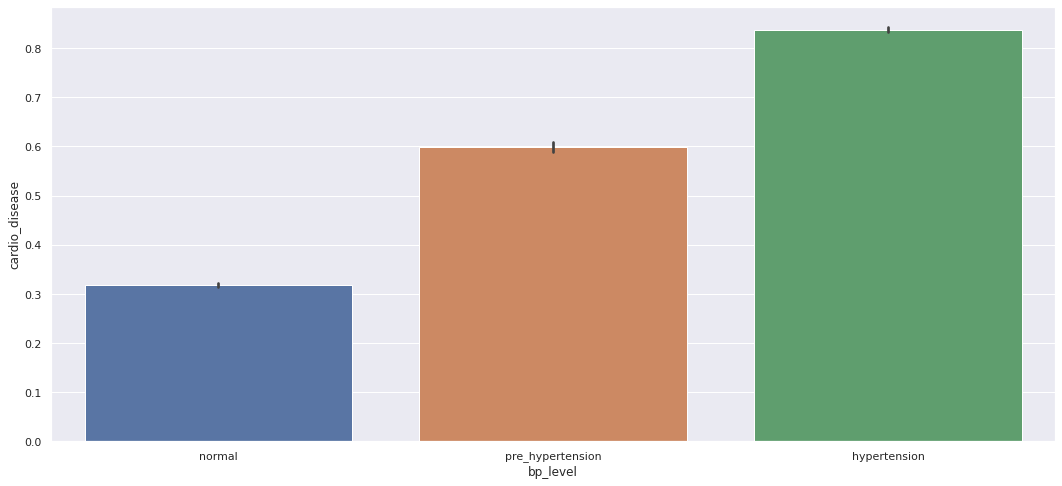

In [320]:
sns.barplot(x = 'bp_level', y = 'cardio_disease', data = df4, order = ('normal', 'pre_hypertension', 'hypertension'));

### 4.2.2. General Hypothesis Overview

In [338]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1. Men are most likely to present cardiovascular diseases', 'True', 'Low'],
       ['H2. People with obesity are most likely to present cardiovascular diseases', 'True', 'High'],
       ['H3. Older people are most likely to present cardiovascular diseases', 'True', 'High'],
       ['H4. People who drink alcohol are most likely to present cardiovascular diseases', 'False', 'Low'],
       ['H5. People who practice regular physical activities are less likely to present cardiovascular diseases', 'True', 'Low'],
       ['H6. People who smoke are most likely to present cardiovascular diseases', 'False', 'Low'],
       ['H7. People who present high cholesterol levels are most likely to present cardiovascular diseases', 'True', 'High'],
       ['H8. High glucose levels people are most likely to present cardiovascular diseases', 'True', 'Moderate'],
       ['H9. People with hypertension are most likely to present cardiovascular diseases', 'True', 'High']
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis                                                                                              Conclusion    Relevance
------------------------------------------------------------------------------------------------------  ------------  -----------
H1. Men are most likely to present cardiovascular diseases                                              True          Low
H2. People with obesity are most likely to present cardiovascular diseases                              True          High
H3. Older people are most likely to present cardiovascular diseases                                     True          High
H4. People who drink alcohol are most likely to present cardiovascular diseases                         False         Low
H5. People who practice regular physical activities are less likely to present cardiovascular diseases  True          Low
H6. People who smoke are most likely to present cardiovascular diseases                                 False         Low
H7. Peop

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

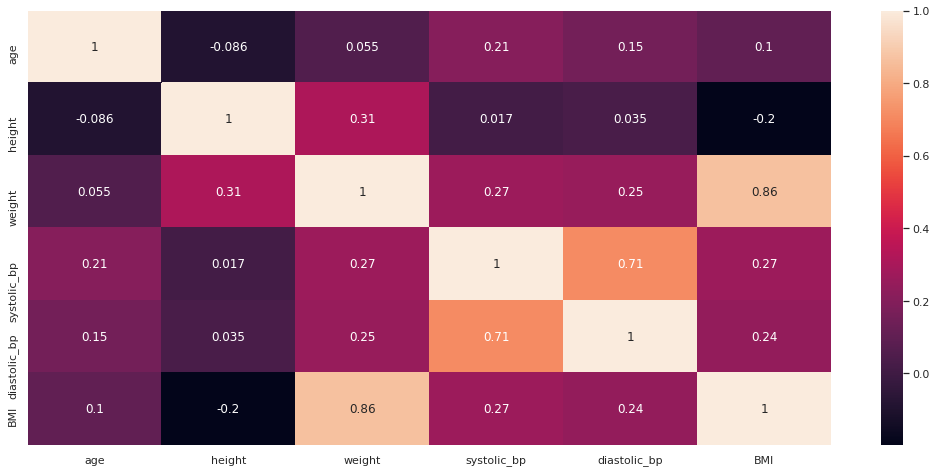

In [36]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])

sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Attributes

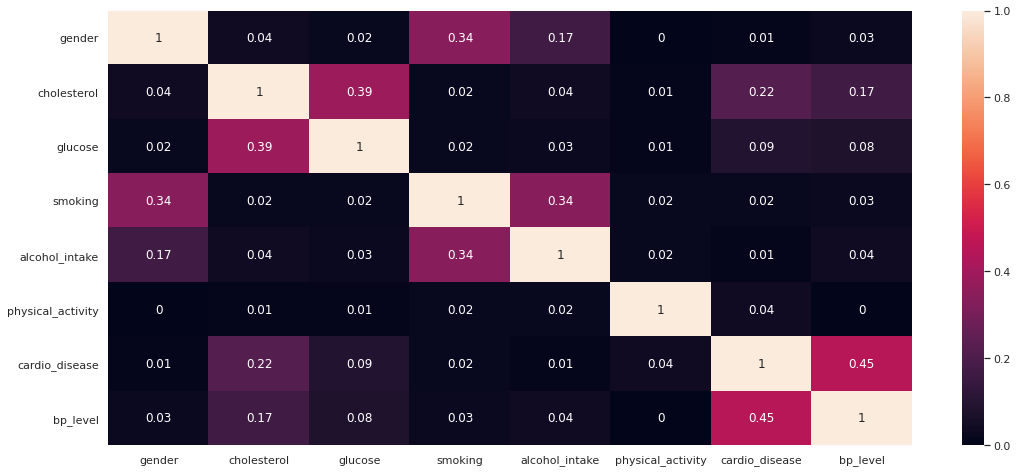

In [37]:
a = df4.select_dtypes(include = 'object')

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in a.columns :
    data_encoded[i] = label.fit_transform(a[i])

rows = []

for var1 in data_encoded:
    col = []
    
    for var2 in data_encoded :
        cramer = cramer_v(data_encoded[var1], data_encoded[var2]) # Cramer's V test
        col.append(round(cramer, 2)) # Keeping of the rounded value of the Cramer's V  
    
    rows.append(col)
    
cramer_results = np.array(rows)
d = pd.DataFrame(cramer_results, columns = data_encoded.columns, index = data_encoded.columns)

sns.heatmap(d, annot = True);

# 5. DATA PREPARATION

In [33]:
df5 = df4.copy()

## 5.1. Normalization

(None)

## 5.2. Rescaling

In [34]:
mms = MinMaxScaler()
rs = RobustScaler()

# age - range 35.00 (no)
df5['age'] = mms.fit_transform(df5[['age']].values)

# height - 0.82 (no)

# weight - 160.00 (RobustScaler)
df5['weight'] = mms.fit_transform(df5[['weight']].values)

# systolic - 160.00 (MinMaxScaler)
df5['systolic_bp'] = mms.fit_transform(df5[['systolic_bp']].values)

# diastolic - 90.00 (MinMaxScaler)
df5['diastolic_bp'] = mms.fit_transform(df5[['diastolic_bp']].values)

# BMI - 46 (MinMaxScaler)
df5['BMI'] = mms.fit_transform(df5[['BMI']].values)

## 5.3. Transformation

### 5.3.1. Response Variable

(None)

### 5.3.2. Encoding

In [35]:
# gender - OrdinalEncoder
assort_dict1 = {'feminine': 1,
               'masculine': 2}
df5['gender'] = df5['gender'].map(assort_dict1)

# cholesterol - OrdinalEncoder
assort_dict2 = {'normal': 1,
               'above_normal': 2,
               'well_above_normal': 3}
df5['cholesterol'] = df5['cholesterol'].map(assort_dict2)

# glucose - OrdinalEncoder
df5['glucose'] = df5['glucose'].map(assort_dict2)

# bp_level - OrdinalEncoder
assort_dict3 = {'normal': 1,
               'pre_hypertension': 2,
               'hypertension': 3}
df5['bp_level'] = df5['bp_level'].map(assort_dict3)

### 5.3.3. Nature Transformation

(None)

# 6. FEATURE SELECTION

In [36]:
df6 = df5.copy()

In [37]:
# removing correlated variables

df6 = df6.drop(columns = ['systolic_bp', 'diastolic_bp'])

## 6.1. Split DataFrame into Training and Test

In [38]:
train, test = train_test_split(df6, test_size = 0.2, random_state = 42, shuffle = True)

X_train = train
y_train = X_train['cardio_disease']

X_test = test
y_test = X_test['cardio_disease']

## 6.2. Boruta as Feature Selector

In [65]:
# conversion of df/series to numpy and remotion of variables that do not compose training ('cardio_disease')
x_train_n = X_train.drop(['cardio_disease'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

# define Boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	10


### 6.2.1. Best Features

In [66]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['cardio_disease'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# unconsidered columns
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [67]:
cols_selected_boruta

['bp_level']

## 6.3. Saving Best Features (Boruta + Selected from EDA)

In [39]:
cols_selected_boruta = ['bp_level', # the only one selected by Boruta
                        'age',
                        'cholesterol',
                        'BMI']

#columns to add
feat_to_add = ['cardio_disease']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7. MACHINE LEARNING MODELS

In [41]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [42]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [80]:
# define CV strategy
cv = StratifiedKFold(n_splits = 10, random_state = None)

## 7.1. Logistic Regression

In [98]:
# model
lr = LogisticRegression()
lr.fit(x_train, y_train)

# prediction
y_hat = lr.predict(x_test)

# # performance
lr_result = ml_performance('Logistic Regression', y_test, y_hat)
lr_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Logistic Regression,0.724714,0.74868,0.656661,0.699658,0.723157


### 7.1.1.  Logistic Regression - Cross Validation

In [127]:
lr_result_cv = cross_validation('Logistic Regression', lr, x_train, y_train, cv)
lr_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Logistic Regression,0.723818,0.762238,0.645041,0.698711,0.789636


## 7.2. Random Forest Classification

In [100]:
# model
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# prediction
y_hat = rf.predict(x_test)

# # performance
rf_result = ml_performance('Random Forest Classifier', y_test, y_hat)
rf_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Random Forest Classifier,0.688252,0.695589,0.642921,0.668219,0.687215


### 7.1.2. Random Forest - Cross Validation

In [101]:
rf_result_cv = cross_validation('Random Forest Classifier', rf, x_train, y_train, cv)
rf_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Random Forest Classifier,0.682723,0.699961,0.632118,0.664298,0.729638


## 7.3. Support Vector Classification

In [102]:
# model
svc = SVC(random_state = 6).fit(x_train, y_train)

# prediction
y_hat = svc.predict(x_test)

# # performance
svc_result = ml_performance('SVC', y_test, y_hat)
svc_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,SVC,0.724933,0.737569,0.677867,0.706459,0.723856


### 7.1.3. Support Vector Classification - Cross Validation

In [103]:
svc_result_cv = cross_validation('SVC Classifier', svc, x_train, y_train, cv)
svc_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,SVC Classifier,0.724602,0.7508,0.666703,0.706213,0.769818


## 7.4. CatBoostClassifier (TO ADD)

## 7.5. XGBoostClassifier  (TO ADD)

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [109]:
modelling_result = pd.concat([lr_result, rf_result, svc_result]).set_index('Model Name')
modelling_result.sort_values('Precision', ascending = False)

,Accuracy,Precision,Recall,F1 Score,AUC ROC
Model Name,,,,,
Logistic Regression,0.724714,0.748680,0.656661,0.699658,0.723157
SVC,0.724933,0.737569,0.677867,0.706459,0.723856
Random Forest Classifier,0.688252,0.695589,0.642921,0.668219,0.687215


### 7.6.2. Real Performance (Cross-Validation)

In [147]:
modelling_result_cv = pd.concat([lr_result_cv, rf_result_cv, svc_result_cv]).set_index('Model Name')
modelling_result_cv.sort_values('Precision', ascending = False)

,Accuracy,Precision,Recall,F1 Score,AUC ROC
Model Name,,,,,
Logistic Regression,0.723818,0.762238,0.645041,0.698711,0.789636
SVC Classifier,0.724602,0.750800,0.666703,0.706213,0.769818
Random Forest Classifier,0.682723,0.699961,0.632118,0.664298,0.729638


# 8. HYPERPARAMETER FINE TUNING

## 8.1. Grid Search - Logistic Regression

In [142]:
grid = {'penalty': ['l1', 'l2'], 
        'C': [0.001, 0.009, 0.01, 0.09, 1, 2, 5, 10],
        'max_iter': list(range(100,800,200)),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr_tuning = GridSearchCV(lr, param_grid = grid, cv = 3, verbose = True, n_jobs = -1)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2708 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 2, 5, 10],
                         'max_iter': [100, 200, 300, 400, 500, 600, 700],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=True)

In [143]:
# Print hyperparameter
log_reg_cv.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

In [146]:
# model
lr_tuned = LogisticRegression(C = 1, max_iter = 100, penalty = 'l2', solver = 'newton-cg')
lr_tuned.fit(x_train, y_train)

# prediction
y_hat = lr_tuned.predict(x_test)

# # performance
lr_result_tuned = ml_performance('Logistic Regression Tuned', y_test, y_hat)
lr_result_tuned

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Logistic Regression Tuned,0.724714,0.74868,0.656661,0.699658,0.723157


## 8.2. Final Model

In [177]:
lr_result_cv

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Logistic Regression,0.723818,0.762238,0.645041,0.698711,0.789636


# 9. BUSINESS PERFORMANCE

In [176]:
n_customers = pd.concat([y_train, y_test], axis=0).shape[0]
print('Final number of costumers: {}'.format(n_customers))

print('\nTotal operational cost of diagnosis: $ {}'.format(n_customers*1000))

print('\nOld tool')
print('Worst scenario profit (55% precision): {}'.format((500-1000)*n_customers))
print('Best scenario profit (65% precision): {}'.format((1500-1000)*n_customers))

print('\nNew tool')
print('Precision percentage: 76.22 %')
print('Worst scenario == Best Scenario profit: {}'.format((2500-1000)*n_customers))

print('\nPercentage improvement in profit (comparing to old best scenario): {} %'.format((2500-1000)/((1500-1000)+(2500-1000))*100))

Final number of costumers: 68561

Total operational cost of diagnosis: $ 68561000

Old tool
Worst scenario profit (55% precision): -34280500
Best scenario profit (65% precision): 34280500

New tool
Precision percentage: 76.22 %
Worst scenario == Best Scenario profit: 102841500

Percentage improvement in profit (comparing to old best scenario): 75.0 %


# 10. CONFUSION MATRIX

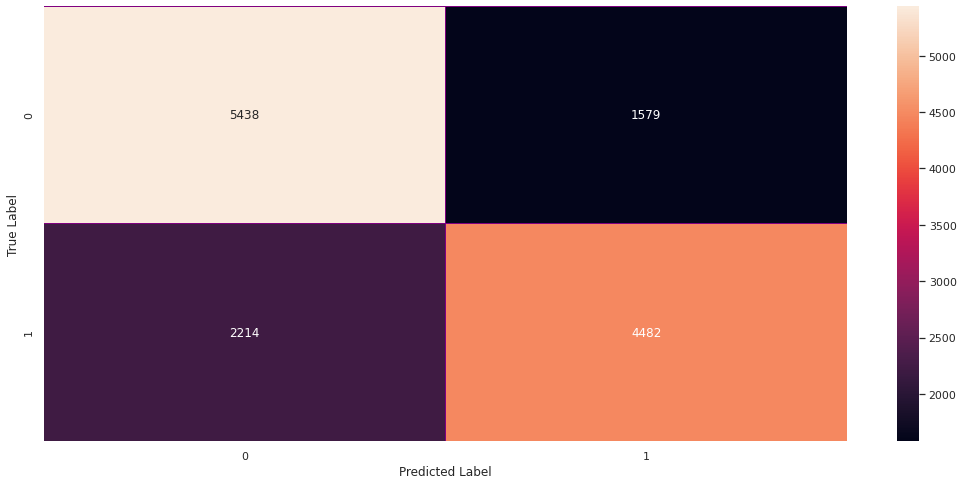

In [145]:
y_true = y_test
y_pred = lr_tuned.predict(x_test)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm,fmt = ".0f", annot = True,linewidths = 0.2, linecolor = "purple")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()